In [1]:
interactive = False
if interactive:
    %matplotlib
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse
import xml.etree.ElementTree as ET

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')
if interactive:
    plt.ion()

In [2]:
def multi_exp_fit(param_data_object, t, corr, result_type="ct", v=1):
    n = [2.0,1.0,1.0,1.0]
    param_info = param_data_object['param_info'][corr].attrs
    for i in range(0,4):
        if f'N{i+2}' in param_info.keys():
            n[i] = float(param_info[f'N{i+2}'])
    #print(n)
    param_data = param_data_object['params']['Values']
    param_samplings = [param_data[f'<MCObservable><Info>{fit_param}<|Info><|MCObservable>'][()] for fit_param in param_info['FitParams']]
    print(corr,len(param_samplings))
#     for i in range(len(param_samplings),10):
#         param_samplings.append(0.0)
    function_vals = []
    function_errs = []
    #print(param_samplings[0][0],param_samplings[0][0]+param_samplings[1][0]**2,param_samplings[0][0]+n[0]*param_samplings[1][0]**2,
    #      param_samplings[0][0]+n[1]*param_samplings[1][0]**2,param_samplings[0][0]+n[2]*param_samplings[1][0]**2,
    #      param_samplings[0][0]+n[3]*param_samplings[1][0]**2)
#     print(param_samplings[2][0], 
#                    param_samplings[3][0], param_samplings[4][0], param_samplings[5][0], 
#                    param_samplings[6][0], param_samplings[7][0])
#     print(param_samplings[4][0],param_samplings[5][0],param_samplings[6][0],param_samplings[7][0])
#     print(param_samplings[0][0],param_samplings[1][0],param_samplings[2][0],param_samplings[3][0])
    for tval in t:
        if v==1:
            if result_type=="ct":
                function_samplings = utils.multi_exp_func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                       param_samplings[3], param_samplings[4], param_samplings[5], 
                       param_samplings[6], param_samplings[7],n[0],n[1], n[2],n[3])
            else:
                function_samplings = utils.multi_exp_func_eff(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                       param_samplings[3], param_samplings[4], param_samplings[5], 
                       param_samplings[6], param_samplings[7],n[0],n[1], n[2],n[3])
        else:
            if result_type=="ct":
                func = utils.multi_exp_func
            else:
                func = utils.multi_exp_func_eff
            if len(param_samplings)==4:
                function_samplings = func(tval, param_samplings[0], param_samplings[1], 0.0, 0.0, 0.0, param_samplings[2], 
                   param_samplings[3], 0.0, 0.0, 0.0) 
            if len(param_samplings)==6:
                function_samplings = func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                   0.0, 0.0, param_samplings[3], param_samplings[4], param_samplings[5], 0.0, 0.0) 
            elif len(param_samplings)==8:
                function_samplings = func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                   param_samplings[3], 0.0, param_samplings[4], param_samplings[5], 
                   param_samplings[6], param_samplings[7], 0.0) # param_samplings[8], param_samplings[9])
            elif len(param_samplings)==10:
                function_samplings = func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                   param_samplings[3], param_samplings[4], param_samplings[5], 
                   param_samplings[6], param_samplings[7], param_samplings[8], param_samplings[9])
        function_vals.append(function_samplings[0])
        function_errs.append(utils.bootstrap_error_by_array(function_samplings))
    return np.array(function_vals),np.array(function_errs)

In [3]:
def get_fit_range(param_data_object, corr):
    try:
        param_info = param_data_object['param_info'][corr].attrs
        return param_info["FinalTmin"], param_info["FinalTmax"]
    except Exception as error:
        print(error)
        return None,None

In [4]:
data_files = {
    "single_hadrons.hdf5":'single_hadrons',
    "rotated_correlators-lambda.hdf5":'rotated_correlators',
    "rotated_correlators-nn.hdf5":'rotated_correlators'
}
# param_files = {
# #     "t=[2,17],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-17.hdf5",
# #     "t=[2,19],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19-3.hdf5",
# #     "t=[2,21],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-21.hdf5",
# #     "t=[2,23],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-23.hdf5",
# #     "t=[2,25],gap=2.5": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-25.hdf5",
# #     "t=[2,25],gap=2.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-2.hdf5",
#     "t=[2,25],gap=1.5": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-15.hdf5",
#     "t=[2,25],gap=1.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-125.hdf5",
#     "t=[2,25],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25.hdf5",
#     "t=[2,25],gap=0.75": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-075.hdf5",
# #     "t=[2,25],gap=0.75,0.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-075-025.hdf5",
# #     "t=[2,25],gap=0.50": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-050.hdf5",
# #     "t=[2,25],gap=0.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-025.hdf5",
# #     "t=[2,19],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19.hdf5",
# #     "t=[2,19]*,gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19-2.hdf5",
# }
# param_files = {
#     "gap=0.75": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10-075.hdf5",
#     "gap=1.0": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10.hdf5",
#     "gap=1.2": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10-12.hdf5",
# }
param_files = {
    "pwm=1.0": "param_samplings_isosinglet_strange_fermionic_multi_new_rebin10.hdf5",
    "pwm=1.5": "param_samplings_isosinglet_strange_fermionic_multi_new15_rebin10.hdf5",
    "pwm=2.0": "param_samplings_isosinglet_strange_fermionic_multi_new2_rebin10.hdf5",
    "pwm=3.0": "param_samplings_isosinglet_strange_fermionic_multi_new3_rebin10.hdf5",
    "pwm=3.5": "param_samplings_isosinglet_strange_fermionic_multi_new35_rebin10.hdf5",
}
johns_data_file = "nucleon_d0_emass_1_0_errs.dat"
n_corr = 'isodoublet S=0 P=(0,0,0) G1g N[SS0] 0'

available_corrs = []
for file in param_files:
    param_samplings = h5py.File(param_files[file],"r")
    available_corrs += list( param_samplings['param_info'].keys() )
    param_samplings.close()

In [5]:
data_files

{'single_hadrons.hdf5': 'single_hadrons',
 'rotated_correlators-lambda.hdf5': 'rotated_correlators',
 'rotated_correlators-nn.hdf5': 'rotated_correlators'}

In [6]:
available_corrs = list(set(available_corrs))
if interactive:
    available_corrs = ['isosinglet S=-1 P=(0,0,0) G1g ROT 1']
    
# available_corrs = ['isosinglet S=0 P=(0,0,0) T1g ROT 0']
# available_corrs = [n_corr, 'isodoublet S=0 PSQ=1 G1 N[SS0] 0','isodoublet S=0 PSQ=2 G N[SS0] 0','isodoublet S=0 PSQ=3 G N[SS0] 0','isodoublet S=0 PSQ=4 G1 N[SS0] 0']

In [7]:
available_corrs

['isosinglet S=-1 P=(0,0,0) G1u ROT 4',
 'isosinglet S=-1 PSQ=3 G ROT 4',
 'isosinglet S=-1 PSQ=3 G ROT 0',
 'isosinglet S=-1 PSQ=2 G ROT 1',
 'isosinglet S=-1 PSQ=2 G ROT 7',
 'isodoublet S=-1 PSQ=1 A2 k[SS1] 0',
 'isosinglet S=-1 PSQ=2 G ROT 8',
 'isosinglet S=-1 P=(0,0,0) G1u ROT 2',
 'isosinglet S=-1 PSQ=2 G ROT 4',
 'isotriplet S=0 PSQ=1 A2m P[SS1] 0',
 'isotriplet S=0 PSQ=2 A2m P[SS0] 0',
 'isosinglet S=-1 PSQ=3 F1 ROT 2',
 'isosinglet S=-1 PSQ=3 G ROT 8',
 'isosinglet S=-1 PSQ=3 G ROT 6',
 'isosinglet S=-1 P=(0,0,0) G1g ROT 1',
 'isosinglet S=-1 P=(0,0,0) G1u ROT 6',
 'isosinglet S=-1 PSQ=3 F1 ROT 4',
 'isodoublet S=-1 PSQ=2 A2 k[SS0] 0',
 'isosinglet S=-1 P=(0,0,0) G1g ROT 0',
 'isosinglet S=-1 PSQ=1 G1 ROT 1',
 'isosinglet S=-1 PSQ=3 F1 ROT 3',
 'isosinglet S=-1 PSQ=3 F1 ROT 1',
 'isosinglet S=-1 PSQ=1 G1 ROT 8',
 'isotriplet S=-1 PSQ=1 G1 S[SS0] 0',
 'isosinglet S=-1 P=(0,0,0) Hu ROT 0',
 'isosinglet S=-1 P=(0,0,0) G1u ROT 0',
 'isosinglet S=-1 PSQ=1 G2 ROT 2',
 'isodoublet S

In [8]:
omit = {}
fit_range = {}
chi2 = {}
for corr in available_corrs:
    fit_range[corr] = {}
    chi2[corr] = {}
for dataset in param_files.keys():
    hdf5_data = h5py.File(param_files[dataset],"r")
    for corr in available_corrs:
        tmin, tmax = get_fit_range(hdf5_data,corr)
        if tmin is not None:
            fit_range[corr][dataset] = tmax-tmin
            chi2[corr][dataset] = hdf5_data['param_info'][corr].attrs['ChiSquarePerDof']
    hdf5_data.close()
            
for corr in available_corrs:
    omit[corr] = []

isosinglet S=-1 P=(0,0,0) G1u ROT 4
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.3242030000486835, 2.004815592287796, 1.0000000000000018, 0.5204788799118271, 0.2786729517974337, 0.15211256526266725, 0.08415608169321843, 0.046983743021171274, 0.0264690761304993, 0.015014332984417386, 0.008571025269970084, 0.004930825688172983, 0.0028447051513586035, 0.0016624489188931447, 0.0009534163185793248, 0.0005703417838910899, 0.00033985836276739323, 0.0001966128397412297, 0.00011664981500744342, 7.194257254557566e-05, 4.4482452538269375e-05, 2.569887276033449e-05, 2.0275001011556397e-05, 1.4130801932536308e-05]
[] []
isosinglet S=-1 P=(0,0,0) G1u ROT 4 10
isosinglet S=-1 P=(0,0,0) G1u ROT 4 10
isosinglet S=-1 P=(0,0,0) G1u ROT 4 10
isosinglet S=-1 P=(0,0,0) G1u ROT 4 10
isosinglet S=-1 P=(0,0,0) G1u ROT 4 10
isosinglet S=-1 P=(0,0,0) G1u ROT 4 10
isosinglet S=-1 P=(0,0,0) G1u ROT 4 6
isosinglet S=-1 P=(0,0,0) G1u ROT 4 6
isosinglet S=-1 P=(0,0

[] []
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isosinglet S=-1 PSQ=2 G ROT 4 8
isotriplet S=0 PSQ=1 A2m P[SS1] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [3304.164230964491, 2718.060509815458, 2300.396473642855, 1979.465179110124, 1721.4198787153598, 1507.1309261295132, 1325.7198350546716, 1169.4288076329133, 1033.0927419877553, 913.7125160280744, 808.832372075007, 716.6553624075542, 635.1946226966883, 563.6332494683421, 500.5062971822952, 444.45065268625183, 394.8014790822388, 350.76101523619116, 311.59846076446644, 276.7085649023013, 245.7749973618918, 218.3888725969077, 194.04603906783845, 172.47995627561096]
[] []
[] []
isotriplet S=0 PSQ=1 A2m P[SS1] 0 10
isotriplet S=0 PSQ=1 A2m P[SS1] 0 10

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 P=(0,0,0) G1u ROT 6 8
isosinglet S=-1 P=(0,0,0) G1u ROT 6 8
isosinglet S=-1 P=(0,0,0) G1u ROT 6 8
isosinglet S=-1 P=(0,0,0) G1u ROT 6 8
isosinglet S=-1 P=(0,0,0) G1u ROT 6 8
isosinglet S=-1 P=(0,0,0) G1u ROT 6 8
isosinglet S=-1 P=(0,0,0) G1u ROT 6 10
isosinglet S=-1 P=(0,0,0) G1u ROT 6 10
isosinglet S=-1 P=(0,0,0) G1u ROT 6 10
isosinglet S=-1 P=(0,0,0) G1u ROT 6 10
isosinglet S=-1 PSQ=3 F1 ROT 4
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.54990801333594, 2.056844768019489, 0.9999999999999999, 0.5073346835467919, 0.2648534651159948, 0.14111683296348718, 0.07634284767148247, 0.04175924468468653, 0.023054206732935068, 0.012811077455578988, 0.0071604722104901064, 0.004029539513508774, 0.0022802044488880557, 0.001294398413874663, 0.0007359055684350462, 0.00041629556350920594, 0.00023640076525779886, 0.00013554403910558956, 7.707220022064536e-05, 4.349589956053936e-05, 2.527451274704593e-05, 1.4450823465184484e-05, 8.67219

isotriplet S=-1 PSQ=1 G1 S[SS0] 0 8
isotriplet S=-1 PSQ=1 G1 S[SS0] 0 8
isotriplet S=-1 PSQ=1 G1 S[SS0] 0 8
isotriplet S=-1 PSQ=1 G1 S[SS0] 0 8
isosinglet S=-1 P=(0,0,0) Hu ROT 0
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.413628985930126, 2.0084667905314464, 1.0000000000000002, 0.5250159973567116, 0.285369361957586, 0.15882844874708504, 0.08991111307337622, 0.051528348459761564, 0.029760981124805186, 0.01730684722979244, 0.010117273585010595, 0.005945241893855128, 0.003503931132319352, 0.0020754617230753537, 0.0012299020524950096, 0.0007310463310350139, 0.0004392736428085779, 0.00026058357344466225, 0.00015549354143664336, 9.270881511527524e-05, 5.576100873437661e-05, 3.334890568063587e-05, 1.986028494581022e-05, 1.2142770172467266e-05]
[] []
isosinglet S=-1 P=(0,0,0) Hu ROT 0 10
isosinglet S=-1 P=(0,0,0) Hu ROT 0 10
isosinglet S=-1 P=(0,0,0) Hu ROT 0 10
isosinglet S=-1 P=(0,0,0) Hu ROT 0 10
isosinglet S=-1 P=(0,0,0) Hu ROT 0 10
is

<ipython-input-9-ec4452c827f1>:80: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  john_data = pd.read_csv(johns_data_file, header=None,skiprows=6,delimiter="   ")


isosinglet S=-1 PSQ=3 G ROT 3
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.597666021801615, 2.0457574856621608, 1.0000000000000007, 0.5169458538482975, 0.2771682058126393, 0.15244294968890731, 0.08537455662981899, 0.04841540215356132, 0.02771207513910042, 0.01596093816624043, 0.009254985665827841, 0.0053934543982794535, 0.003157375098540665, 0.001858618980181253, 0.0010963500444049977, 0.0006472708386177987, 0.0003844982695947619, 0.00022741816512862476, 0.00013530393414738537, 7.973010429553756e-05, 4.741549402682838e-05, 2.8703571015797935e-05, 1.6655983876800695e-05, 9.617129065970057e-06]
[] []
isosinglet S=-1 PSQ=3 G ROT 3 10
isosinglet S=-1 PSQ=3 G ROT 3 10
isosinglet S=-1 PSQ=3 G ROT 3 10
isosinglet S=-1 PSQ=3 G ROT 3 10
isosinglet S=-1 PSQ=3 G ROT 3 10
isosinglet S=-1 PSQ=3 G ROT 3 10
isosinglet S=-1 PSQ=3 G ROT 3 8
isosinglet S=-1 PSQ=3 G ROT 3 8
isosinglet S=-1 PSQ=3 G ROT 3 8
isosinglet S=-1 PSQ=3 G ROT 3 8
isosinglet S=-1

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isosinglet S=-1 PSQ=3 G ROT 12 6
isodoublet S=0 PSQ=3 G N[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.4418428617978365, 0.2486220510358478, 0.1495836147078366, 0.0936604858910576, 0.06019900157139759, 0.039406069541001586, 0.026153529192860566, 0.017527557725462106, 0.011826705283828868, 0.008024393311629293, 0.005471038874260594, 0.0037484666136732643, 0.002580468500857059, 0.0017837765972602891, 0.0012335201128897586, 0.0008563541665794607, 0.000595406273335784, 0.00041272453099990854, 0.00028789167249004973, 0.0001998880122958776, 0.0001391522818257036, 9.757764441545961e-05, 6.842503878610119e-05, 4.745367504710869e-05]
[] []
[] []
isodoublet S=0 PSQ=3 G N[SS0] 0 10

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=2 G ROT 13 8
isosinglet S=-1 PSQ=1 G2 ROT 0
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.509145584696267, 2.029780354890502, 1.0000000000000002, 0.5194680497639469, 0.279318625792203, 0.1537623486904894, 0.08608210932026379, 0.04877327094255883, 0.027836439750479565, 0.01600472267188914, 0.009242515324837774, 0.005369050384782069, 0.003128959332465169, 0.0018320010918905971, 0.0010740674740603734, 0.000632310373282292, 0.00037299297565675623, 0.0002197699361846548, 0.0001295332627268639, 7.619847913139438e-05, 4.561913368742737e-05, 2.6821747843141173e-05, 1.5718514015132264e-05, 9.387235509669856e-06]
[] []
isosinglet S=-

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 3 6
isosinglet S=-1 P=(0,0,0) G1g ROT 4
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [5.811043020209683, 2.319432933504646, 0.9999999999999994, 0.4527438995507434, 0.21191139766065378, 0.10176722320207117, 0.04977919246407804, 0.024714879928622244, 0.012429637055756903, 0.0063098492480370295, 0.0031551534568699923, 0.0015623314070556235, 0.0008096609278712707, 0.00040431400880999914, 0.0001989620588214723, 9.180994577348503e-05, 5.00431231957463e-05, 1.4820126425460662e-05, 2.3471826494170188e-05, 4.646828107159173e-06, 2.2053832237812624e-06, -1.478001318816412e-07, -5.753729915392174e-06, 1.082051360

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 P=(0,0,0) G1g ROT 4 10
isosinglet S=-1 P=(0,0,0) G1g ROT 4 6
isosinglet S=-1 P=(0,0,0) G1g ROT 4 6
isosinglet S=-1 P=(0,0,0) G1g ROT 4 6
isosinglet S=-1 P=(0,0,0) G1g ROT 4 6
isosinglet S=-1 P=(0,0,0) G1g ROT 4 6
isosinglet S=-1 P=(0,0,0) G1g ROT 4 6
isosinglet S=-1 P=(0,0,0) G1g ROT 4 6
isosinglet S=-1 P=(0,0,0) G1g ROT 4 6
isosinglet S=-1 PSQ=1 G1 ROT 5
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.38301523600736, 2.0074820742474664, 1.0000000000000004, 0.5235080319523974, 0.2832573398439743, 0.156800866355789, 0.08826480680442217, 0.05027715199480165, 0.028895131410208878, 0.016737688122773143, 0.009759272993042942, 0.005730260629889533, 0.003365703874992414, 0.0019906059068454324, 0.0011816703540724794, 0.0007037218759289014, 0.0004222583914618897, 0.00024881991252188206, 0.0001456565919906609, 8.826262140757762e-05, 5.443594229752842e-05, 3.146272507396591e-05, 1.9215097029385447e-05, 1.2794276834379601e-05]
[] []

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=2 G ROT 12 6
isosinglet S=-1 PSQ=3 F2 ROT 3
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.840060790261152, 2.0997379623502246, 1.0, 0.5033201166688683, 0.26263860064410716, 0.14050221711355668, 0.07651740958845034, 0.042193417289605316, 0.02346599440150602, 0.013141573620318958, 0.0073974805988621375, 0.004190056287500146, 0.0023828119503693057, 0.0013569683533007518, 0.0007764857922355723, 0.0004491208444907968, 0.0002562831261244672, 0.00014885332566148357, 8.538539790134379e-05, 4.993466940800314e-05, 2.855046207013306e-05, 1.624196662759757e-05, 9.453680092448887e-06, 5.960922854493294e-06]
[] []
isosinglet S=-1 PSQ=3 F

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=3 F2 ROT 5 6
isosinglet S=-1 PSQ=3 F2 ROT 5 6
isosinglet S=-1 PSQ=3 F2 ROT 5 6
isosinglet S=-1 PSQ=3 F2 ROT 5 6
isosinglet S=-1 PSQ=3 F2 ROT 5 6
isosinglet S=-1 PSQ=3 F2 ROT 5 6
isosinglet S=-1 PSQ=3 F2 ROT 5 6
isosinglet S=-1 PSQ=3 F2 ROT 5 6
isosinglet S=-1 PSQ=3 F2 ROT 5 6
isotriplet S=-1 PSQ=2 G S[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.7563017577751596, 0.4137070760984816, 0.24074463207086977, 0.14527082141812214, 0.08978780756928231, 0.056429495896413794, 0.03589793188376761, 0.023038092340598098, 0.01487542997499519, 0.009657042825224945, 0.006294797727678865, 0.00412066205887269, 0.0027057481500864906, 0.0017823801173791993, 0.001176437723728102, 0.0007777757048812786, 0.0005155901199763958, 0.0003412215777054416, 0.00022610519250698758, 0.00014986597428042484, 9.947358526149777e-05, 6.619859973198453e-05, 4.3882555732567946e-05, 2.9243464611859864e-05]
[] []
[] []
isotriplet S=-1 PSQ=2 G S[SS0] 0 10

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 PSQ=1 G2 ROT 6 6
isosinglet S=-1 P=(0,0,0) Hu ROT 2
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.473104222148331, 2.036534861630339, 1.0000000000000002, 0.5136884261818834, 0.272037954147582, 0.14740984192204837, 0.08122219654965479, 0.045342762573038944, 0.02555325080830063, 0.014518524340106734, 0.008310546334287763, 0.004791787036509756, 0.0027776841625743584, 0.0016211364889130604, 0.0009484664851056127, 0.0005553610852642165, 0.00032982662993641127, 0.00019426870867495676, 0.00011422846594201901, 6.75630439119033e-05, 4.075760739425383e-05, 2.44311814177692e-05, 1.511714373554119e-05, 8.643242755975386e-06]
[] []
isosinglet S=-1 P=(0,0,0) Hu ROT 2 10
iso

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


 8
isosinglet S=-1 PSQ=3 G ROT 11 8
isosinglet S=-1 PSQ=3 G ROT 11 6
isosinglet S=-1 PSQ=3 G ROT 11 6
isosinglet S=-1 PSQ=3 G ROT 11 6
isosinglet S=-1 PSQ=3 G ROT 11 6
isosinglet S=-1 PSQ=3 G ROT 11 6
isosinglet S=-1 PSQ=3 G ROT 11 6
isosinglet S=-1 PSQ=3 G ROT 11 6
isosinglet S=-1 PSQ=3 G ROT 11 6
isosinglet S=-1 PSQ=1 G1 ROT 0
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [2.967216275970934, 1.6690347056514643, 1.0000000000000002, 0.6220093451052604, 0.396574782486537, 0.2572327463743017, 0.1689792280519194, 0.11201752220102655, 0.07473957582813974, 0.05013454039914465, 0.03377960930272505, 0.022850096799962718, 0.015514406272026401, 0.010563647971604128, 0.007206456174327517, 0.004921252052439437, 0.003368189399708083, 0.002304481622717871, 0.0015791230925462363, 0.001082720153895416, 0.0007441388974238818, 0.0005111883912866507, 0.00035151344440353965, 0.00024145349067983366]
[] []
isosinglet S=-1 PSQ=1 G1 ROT 0 10
isosinglet S=-1 PS

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 P=(0,0,0) G1u ROT 5 10
isosinglet S=-1 PSQ=2 G ROT 11
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [5.7623018090077025, 2.306640781882788, 0.9999999999999992, 0.45599317592219996, 0.21546877566716316, 0.10438975169304374, 0.051608219017988906, 0.025950648479906642, 0.013215059022707986, 0.006790378794643052, 0.0035056668793424753, 0.0018738266252140872, 0.0009988423814529025, 0.0005406688346898226, 0.00030603541362353356, 0.0001750522697770414, 9.547405697649808e-05, 7.214038146716887e-05, 4.326263116334552e-05, 2.801959983713261e-05, 1.2149245650313167e-05, 5.6810129791117695e-06, 3.4042906117983862e-06, 3.7066856

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=2 G ROT 11 8
isosinglet S=-1 PSQ=2 G ROT 11 10
isosinglet S=-1 PSQ=2 G ROT 11 10
isosinglet S=-1 PSQ=2 G ROT 11 10
isosinglet S=-1 PSQ=2 G ROT 11 10
isosinglet S=-1 PSQ=2 G ROT 11 8
isosinglet S=-1 PSQ=2 G ROT 11 8
isosinglet S=-1 PSQ=2 G ROT 11 8
isosinglet S=-1 PSQ=2 G ROT 11 8
isosinglet S=-1 P=(0,0,0) G1g ROT 2
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.696238069174188, 2.0644739722392877, 0.9999999999999997, 0.5135105575884337, 0.2740061345110222, 0.15018632860465128, 0.08398271498846757, 0.047610151037879384, 0.027258649259097083, 0.015729743491422324, 0.00913663642198841, 0.005339171859946667, 0.0031326050314148322, 0.0018477044262728182, 0.0010933871995232164, 0.0006491230850662889, 0.0003864106826088375, 0.00022952662968628342, 0.00013743017991279724, 8.123917719411154e-05, 4.924240424817385e-05, 2.9863867971788256e-05, 1.7051318693647356e-05, 1.0930298510964788e-05]
[] []
isosinglet S=-1 P=(0,0,0) G1g 

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=1 G1 ROT 7 6
isosinglet S=-1 PSQ=1 G1 ROT 7 6
isosinglet S=-1 PSQ=1 G1 ROT 7 6
isosinglet S=-1 PSQ=1 G1 ROT 7 6
isosinglet S=-1 PSQ=1 G1 ROT 7 6
isosinglet S=-1 PSQ=1 G1 ROT 7 6
isosinglet S=-1 PSQ=1 G1 ROT 7 6
isosinglet S=-1 PSQ=1 G1 ROT 7 6
isodoublet S=-1 PSQ=4 A2 k[SS1] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [1011.9572749159324, 711.8373526767446, 518.965052496072, 386.3493412209597, 291.4834931027483, 221.84546273609982, 169.90994218837645, 130.67873380758272, 100.73255808249509, 77.81953124818604, 60.199910490190504, 46.645827201233764, 36.166664606496745, 28.07021981489403, 21.794960203562944, 16.92996329649849, 13.15351069982844, 10.225713561896965, 7.947602152444254, 6.178338435017393, 4.804722399898376, 3.7391572110232194, 2.909331916717361, 2.2650535366040208]
[] []
[] []
isodoublet S=-1 PSQ=4 A2 k[SS1] 0 10
isodoublet S=-1 PSQ=4 A2 k[SS1] 0 10
isodoublet S=-1 PSQ=4 A2 k[SS1] 0 10
isodoublet S=-1 PSQ=4 

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=2 G ROT 14 6
isosinglet S=-1 PSQ=3 F1 ROT 5
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.769954577615072, 2.1172656919423525, 0.9999999999999991, 0.48979550908455366, 0.2460523978179385, 0.12583073711807521, 0.06523825319422057, 0.03419343335391557, 0.01805805964123365, 0.009609110716393199, 0.005151849085087064, 0.002771790153281258, 0.001500914352860392, 0.0008155918219108058, 0.00043788408619262957, 0.0002405126164118127, 0.00013212110115493089, 6.781655853062904e-05, 3.7410204030980326e-05, 1.76899467985698e-05, 1.206992086914247e-05, 7.4721292947574225e-06, 5.5635003354055045e-06, 3.728043241754315e-06]


..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[] []
isosinglet S=-1 PSQ=3 F1 ROT 5 8
isosinglet S=-1 PSQ=3 F1 ROT 5 8
isosinglet S=-1 PSQ=3 F1 ROT 5 8
isosinglet S=-1 PSQ=3 F1 ROT 5 8
isosinglet S=-1 PSQ=3 F1 ROT 5 8
isosinglet S=-1 PSQ=3 F1 ROT 5 8
isosinglet S=-1 PSQ=3 F1 ROT 5 8
isosinglet S=-1 PSQ=3 F1 ROT 5 8
isosinglet S=-1 PSQ=3 F1 ROT 5 6
isosinglet S=-1 PSQ=3 F1 ROT 5 6
isosinglet S=-1 PSQ=1 G1 ROT 3
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.293329582507113, 1.9809946781718275, 1.0000000000000009, 0.5325400342511616, 0.2937297076379998, 0.16600560948362286, 0.09548026964892625, 0.05559920293079847, 0.032661704295732306, 0.019309638041570727, 0.011488286943280312, 0.006868084400740235, 0.004123251477962637, 0.0024862636738697194, 0.0014993245980779624, 0.0009090108122454891, 0.0005518414294907376, 0.00033447222655320495, 0.00020390512732167468, 0.00012467696795281688, 7.578860243567005e-05, 4.666861805587551e-05, 2.8436920903840655e-05, 1.7782378653614113e-05]
[] []
i

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=1 G1 ROT 6 6
isosinglet S=-1 PSQ=1 G1 ROT 6 6
isosinglet S=-1 PSQ=1 G1 ROT 6 6
isosinglet S=-1 PSQ=1 G1 ROT 6 6
isosinglet S=-1 PSQ=1 G1 ROT 6 6
isosinglet S=-1 PSQ=1 G1 ROT 6 6
isosinglet S=-1 PSQ=1 G1 ROT 6 6
isosinglet S=-1 PSQ=1 G1 ROT 6 6
isosinglet S=-1 PSQ=1 G1 ROT 6 6
isotriplet S=-1 PSQ=3 G S[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.45647770026382256, 0.246987078743453, 0.14222518983398022, 0.0849285055284272, 0.05194074061741919, 0.03229693773025699, 0.020323497452781537, 0.012899720639574532, 0.008236247154482495, 0.00528654723538166, 0.003406714955893142, 0.0022048547089173944, 0.0014315176143490916, 0.0009323821655883508, 0.0006078854446642223, 0.0003974344429134834, 0.00026057701360894585, 0.00017042465326377808, 0.00011154839772458642, 7.303545697355819e-05, 4.781364446906661e-05, 3.1616189959896476e-05, 2.0753848950125465e-05, 1.3747389549954501e-05]
[] []
[] []
isotriplet S=-1 PSQ=3 G S[SS0] 

isosinglet S=-1 P=(0,0,0) G1g L[SS0] 0 10
isosinglet S=-1 P=(0,0,0) G1g L[SS0] 0 10
isosinglet S=-1 P=(0,0,0) G1g L[SS0] 0 10
isosinglet S=-1 P=(0,0,0) G1g L[SS0] 0 10
isosinglet S=-1 PSQ=3 G ROT 5
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.623086001611398, 2.0523964491251383, 1.0000000000000004, 0.5150206134535324, 0.27501438599932576, 0.15058475507762076, 0.08396422384845564, 0.047415892892944116, 0.027016630621728665, 0.015488757878164876, 0.008935666050206844, 0.00519016992405001, 0.0030230928354401205, 0.0017733352585965366, 0.0010388037610744667, 0.000611841055975867, 0.00036288294176302626, 0.0002132402157999228, 0.00012585107097941666, 7.468758162493337e-05, 4.434938296096241e-05, 2.6041979660742353e-05, 1.5387427176132737e-05, 8.775560765604993e-06]
[] []
isosinglet S=-1 PSQ=3 G ROT 5 10
isosinglet S=-1 PSQ=3 G ROT 5 10
isosinglet S=-1 PSQ=3 G ROT 5 10
isosinglet S=-1 PSQ=3 G ROT 5 10
isosinglet S=-1 PSQ=3 G ROT 5 8
isosin

isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [589.8192826972465, 462.3548326440542, 373.6255038534519, 307.5400995481155, 256.1718580175789, 215.10801500253692, 181.61263107897673, 153.8997412820057, 130.68447533381106, 111.16500047802285, 94.66398431805288, 80.70265424641937, 68.84182391687347, 58.773311939791306, 50.211945036733766, 42.905599577400324, 36.66687752920694, 31.340408027084287, 26.784993584116123, 22.889868579311273, 19.56612991839546, 16.731070037161942, 14.306331087122109, 12.235898958483395]
[] []
[] []
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 10
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 10
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 10
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 10
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 10
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 10
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 10
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 10
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0 6
isodoublet S=

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


 6
isosinglet S=-1 P=(0,0,0) G1u ROT 7 6
isosinglet S=-1 P=(0,0,0) G1u ROT 7 6
isosinglet S=-1 P=(0,0,0) G1u ROT 7 6
isosinglet S=-1 P=(0,0,0) G1u ROT 7 6
isosinglet S=-1 P=(0,0,0) G1u ROT 7 6
isosinglet S=-1 P=(0,0,0) G1u ROT 7 6
isosinglet S=-1 P=(0,0,0) G1u ROT 7 6
isosinglet S=-1 P=(0,0,0) G1u ROT 7 6
isosinglet S=-1 PSQ=2 G ROT 3
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.506616583265466, 2.025508554435729, 1.0000000000000007, 0.5222188637513898, 0.2829248707474684, 0.15726715316642176, 0.08905674829472955, 0.05107028709833164, 0.029564720035611385, 0.017231419344077514, 0.010105090961717722, 0.00595983517650439, 0.003532857160936034, 0.0021019503599381526, 0.0012546511545482191, 0.000750340306781919, 0.00045023598659422423, 0.0002693747920650755, 0.00016246913092645267, 9.662361870318547e-05, 5.794580504151698e-05, 3.5249304869490134e-05, 2.1346100455920534e-05, 1.2945130872870952e-05]
[] []
isosinglet S=-1 PSQ=2 G ROT 3 10
i

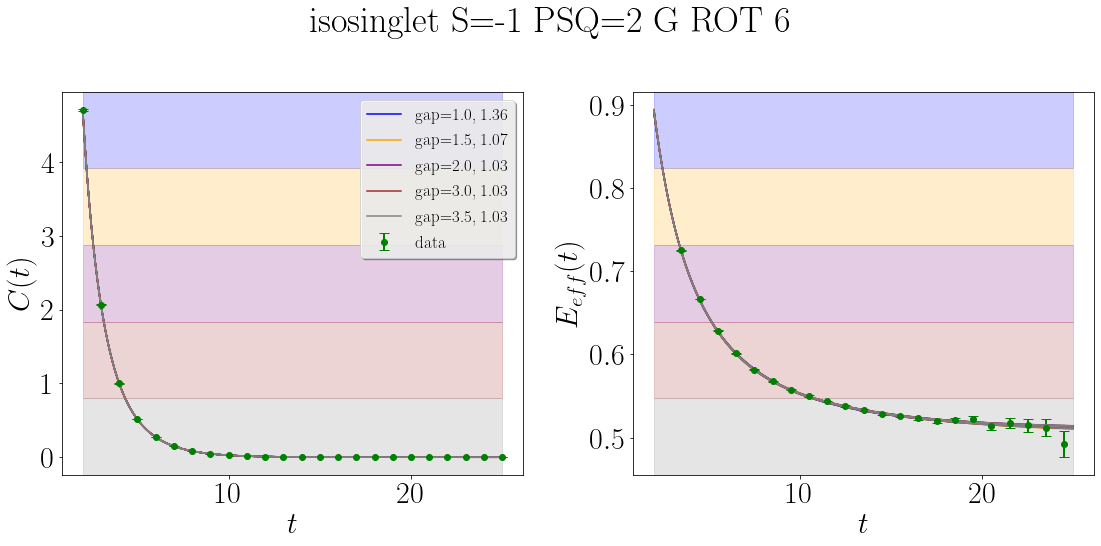

In [9]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figwidth(16)
f.set_figheight(8)
plot_tmin = 2
for corr in available_corrs:
    print(corr)
    ax1.clear()
    ax2.clear()
    f.suptitle(corr.replace("_"," "))
    i=0
    for data_file in data_files.keys():
        hdf5_data = h5py.File(data_file,"r")
        this_t, this_corr, this_err = utils.collectCorrEstimates(hdf5_data,corr,tag=data_files[data_file])
        print( this_t, this_corr )
        if this_t:
            itmin = np.where(np.array(this_t)>=plot_tmin)[0][0]
            ax1.errorbar( this_t[itmin:], this_corr[itmin:],this_err[itmin:], label="data",  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
        this_t, this_corr, this_err = utils.collectEnergyEstimates(hdf5_data,corr,tag=data_files[data_file])
        if this_t:
            itmin = np.where(np.array(this_t)>=plot_tmin)[0][0]
            ax2.errorbar( this_t[itmin:], this_corr[itmin:],this_err[itmin:], label="data",  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
#         this_t, this_corr, this_err = utils.collectEnergyEstimates(hdf5_data,corr,tag=data_files[data_file],func=2)
#         if this_t:
#             ax2.errorbar( this_t, this_corr,this_err, label="data*",  color=settings.colors[i],mfc="white", marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
        hdf5_data.close()
    i=1
    for dataset in param_files.keys():
        if dataset not in omit[corr]:
            hdf5_data = h5py.File(param_files[dataset],"r")
            tmin, tmax = get_fit_range(hdf5_data,corr)
            if tmin is not None:
                t = np.linspace(2.0,25.0,1000)
                itmin = np.where(t>=tmin)[0][0]
                itmax = np.where(t>=tmax)[0][0]
#                 itmin = np.where(t>=plot_tmin)[0][0]
                fit_vals = np.array([])
                try:
                    fit_vals, fit_errs = multi_exp_fit(hdf5_data,t,corr,"ct",2)
                except Exception as error:
                    print(error) #pass
                data_label = f"{dataset}, {round(hdf5_data['param_info'][corr].attrs['ChiSquarePerDof'],2)}"
                if fit_vals.any():
    #                 ax1.plot(t,fit_vals,ls="--",color=settings.colors[i])
    #                 ax1.plot(t,fit_vals+fit_errs,ls="--",color=settings.colors[i])
    #                 ax1.plot(t,fit_vals-fit_errs,ls="--",color=settings.colors[i])
                    ax1.axvspan(tmin, tmax, ymin=1.0-(i)/len(param_files),ymax=1.0-(i-1)/len(param_files), alpha=0.2,color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax],label=data_label,color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax]+fit_errs[itmin:itmax],color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax]-fit_errs[itmin:itmax],color=settings.colors[i])

                fit_vals = np.array([])
                try:
                    fit_vals, fit_errs = multi_exp_fit(hdf5_data,t,corr,"eff",2)
                except Exception as error:
                    print(error) #pass

                if fit_vals.any():
#                     try:
#                         stable_itmin = np.where(fit_errs>1.0)[0][-1]
#                     except:
#                         stable_itmin = np.where(fit_errs<1.0)[0][0]
                    ax2.axvspan(tmin, tmax, ymin=1.0-(i)/len(param_files),ymax=1.0-(i-1)/len(param_files), alpha=0.2,color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:]+fit_errs[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:]-fit_errs[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax],label=data_label,color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax]+fit_errs[itmin:itmax],color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax]-fit_errs[itmin:itmax],color=settings.colors[i])

                hdf5_data.close()
                i+=1
    
    ax1.set_xlabel("$t$")
    ax1.set_ylabel("$C(t)$")
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("$E_{eff}(t)$")
    ax1.legend()
        
    if corr==n_corr:
        john_data = pd.read_csv(johns_data_file, header=None,skiprows=6,delimiter="   ")
        ax2.errorbar(john_data[0],john_data[1],john_data[2],label="john",color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0)
#         ax2.legend()
        
    plt.tight_layout()
    plt.savefig(corr+".png")

In [10]:
hdf5_data = h5py.File("param_samplings_isosinglet_strange_fermionic_multi_rebin10.hdf5","r")
print(hdf5_data['params']['Values'].keys() )
hdf5_data.close()

<KeysViewHDF5 ['<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 112 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 12 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 212 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 312 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 412 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 512 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 612 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 712 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 112 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 12 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 212 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 312 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 412 n re<|Info><|MCOb

In [11]:

hdf5_data.close()